# Multi source Capacitated Facility Location Problem

The Multi-Source Capacitated Facility Location Problem (MSCFLP) aims to decide where to open facilities and how to allocate customer demand to them. The goal is to minimize total costs (fixed facility costs and transportation costs) while ensuring each facility's limited capacity isn't exceeded and all customer demands are met. Crucially, customers can be served by multiple facilities in this problem.

![cflp](cflp.jpg)
(https://link.springer.com/article/10.1057/s41274-016-0155-6/figures/1)

In [1]:
# Install dependencies
! pip install -q gamspy

In [2]:
import random
random.seed(42)

First, we need to define the data that describes our problem. We can open new facilities at every grid point, and our customers are located within a circular area in the middle.

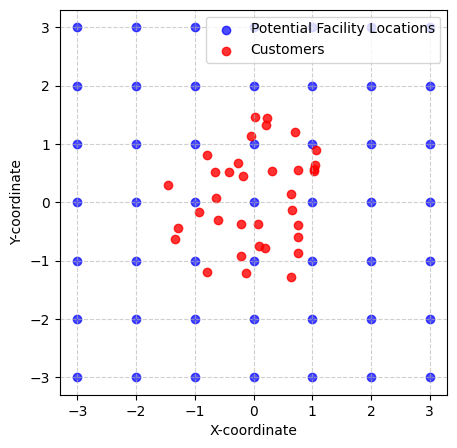

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x_min, x_max = -3, 3
y_min, y_max = -3, 3
num_points_per_side = 7

x_grid = np.linspace(x_min, x_max, num_points_per_side)
y_grid = np.linspace(y_min, y_max, num_points_per_side)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

center_x, center_y = 0, 0
radius = 1.5
num_circle_points = 35

angles = 2 * np.pi * np.random.rand(num_circle_points)
radii = radius * np.sqrt(np.random.rand(num_circle_points))

circle_x_coords = center_x + radii * np.cos(angles)
circle_y_coords = center_y + radii * np.sin(angles)


def plot_locations(facility_selection=None):

    plt.figure(figsize=(5, 5))

    plt.scatter(
        X_grid, Y_grid, color="blue", label="Potential Facility Locations", alpha=0.7
    )

    plt.scatter(
        circle_x_coords, circle_y_coords, color="red", label="Customers", alpha=0.8
    )

    if facility_selection is not None:
        plt.scatter(
            facility_selection[0],
            facility_selection[1],
            color="green",
            label="Opened Facilities",
        )

    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(loc="upper right")
    plt.show()


plot_locations()

For our model, we will later need the distances between facilities and customers. Opening facilities in the center is more expensive than opening them on the outskirts. For simplicity, let's assume that all facilities have the same capacity and all customers have the same demand.

In [4]:
facility_coords = np.vstack((X_grid.flatten(), Y_grid.flatten()))
customer_coords = np.vstack((circle_x_coords.flatten(), circle_y_coords.flatten()))

distances_data = np.zeros((facility_coords.shape[1], customer_coords.shape[1]))
for i in range(facility_coords.shape[1]):
    for j in range(customer_coords.shape[1]):
        # Euclidean distance formula: sqrt((x2-x1)^2 + (y2-y1)^2)
        distances_data[i, j] = np.sqrt(
            (facility_coords[0, i] - customer_coords[0, j]) ** 2
            + (facility_coords[1, i] - customer_coords[1, j]) ** 2
        )


inner_radius = 4  # Facilities within this radius are considered "middle"
expensive_cost_range = (2000, 4000)
cheap_cost_range = (1000, 2000)
small_capacity_range = (50, 100)
big_capacity_range = (100, 200)


distances_from_center = np.linalg.norm(
    facility_coords - np.array([[center_x], [center_y]]), axis=0
)

opening_costs_data = [
    (
        round(np.random.uniform(expensive_cost_range[0], expensive_cost_range[1]))
        if dist <= inner_radius
        else round(np.random.uniform(cheap_cost_range[0], cheap_cost_range[1]))
    )
    for dist in distances_from_center
]

capacity_data = [200 for _ in range(facility_coords.shape[1])]

demand_data = [50 for _ in range(customer_coords.shape[1])]

### Model Definition
We need to import GAMSPy and create a container for our model.

In [5]:
import gamspy as gp

m = gp.Container()


Start by eliminating transportation costs; simply beam the goods to the customer.

We need two sets:

$$
\begin{array}{rcl}
\mathcal{I} :& \text{Set of potential facilities}  \\
\mathcal{J} :& \text{Set of customers}
\end{array}
$$


In [6]:
i = gp.Set(
    m,
    name="i",
    records=[f"i{i}" for i in range(facility_coords.shape[1])],
    description="Potential facility locations",
)

j = gp.Set(
    m,
    name="j",
    records=[f"j{j}" for j in range(customer_coords.shape[1])],
    description="Customers",
)

And three parameters
$$
\begin{array}{rcl}
f_i :& \text{Fixed cost for opening facility } i  \\
q_i :& \text{Capacity of facility } i  \\
d_j :& \text{Demand of customer } j
\end{array}
$$

In [7]:
opening_cost = gp.Parameter(
    m,
    "f_i",
    domain=i,
    records=[[f"i{i}", value] for i, value in enumerate(opening_costs_data)],
    description="Fixed cost for opening facility i",
)

capacity = gp.Parameter(
    m,
    "q_i",
    domain=i,
    records=[[f"i{i}", value] for i, value in enumerate(capacity_data)],
    description="Capacity of facility i",
)

demand = gp.Parameter(
    m,
    "d_j",
    domain=j,
    records=[[f"j{j}", value] for j, value in enumerate(demand_data)],
    description="Demand of customer j",
)

Decide for each facility if it will be opened:

$$ Y_i \in \lbrace 0, 1\rbrace \hspace{1cm} \forall i\in \mathcal{I} \tag{3} $$

In [8]:
y = gp.Variable(
    m,
    "y",
    type="binary",
    domain=i,
    description="Is facility i open",
)

We want to minimize the opening costs:

$$\min \sum_{i \in \mathcal{I} \hspace{0.75mm} | \hspace{0.75mm} i < |I|} f_i Y_i \tag{1} $$

In [9]:
obj = gp.Sum(i, opening_cost[i] * y[i])

While fulfilling the demand of all customers:

$$ \sum_{i\in \mathcal{I}} q_i Y_i \ge \sum_{j\in \mathcal{J}} d_j \hspace{1cm} \tag{2} $$

In [10]:
facilities_meet_demand = gp.Equation(
    m,
    name="facilities_meet_demand",
    description="The facilities need to be able to fulfill the demand",
)

# Note this is a scalar equation so we need to access [...]
facilities_meet_demand[...] = gp.Sum(i, capacity[i] * y[i]) >= gp.Sum(j, demand[j])

Now we just combine everything into a model:

In [11]:
cflp_beam = gp.Model(
    m,
    name="cflp_beam",
    equations=[facilities_meet_demand],
    problem="MIP",
    sense=gp.Sense.MIN,
    objective=obj,
)

cflp_beam.solve(
    solver="CPLEX",
)


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,17592.0,2,50,MIP,CPLEX,0.0


And we can display our solution:

Optimal solution: 17592.0
Number of facilities open: 9.0


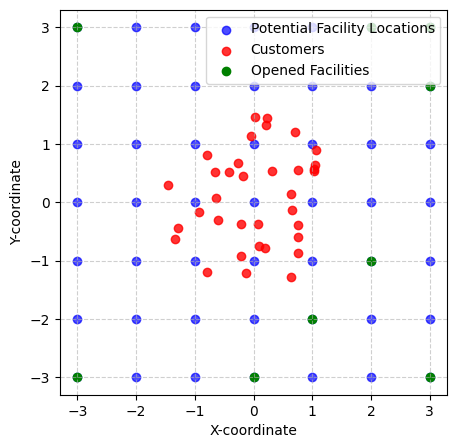

In [ ]:
print(f"Optimal solution: {cflp_beam.objective_value}")
print(f"Number of facilities open: {y.records['level'].sum()}")
plot_locations(facility_coords[:, y.records["level"] == 1])

Note that, without considering transportation costs, we would obviously open the facilities outside.

Let's save the current solution for y in a parameter so that we can use it for comparisons later.

In [13]:
y_beam = gp.Parameter(m, "y_beam", domain=i)
y_beam[i] = y.l[i]

# Expand the Model Yourself

Now let's add transportation costs. We then need to decide which customer is supplied by which facility.

$$
\begin{array}{rcl}
c_{ij} :=& \text{Unit transportation cost from facility } i \text{ to customer } j  \\
X_{ij} :=& \text{Fraction of the fulfilled demand of customer } j \text{ by facility } i  \\
\end{array}
$$

$$X_{ij} \in \left[ 0, 1 \right]  $$

In [14]:
unit_transportation_cost = 200

transportation_cost = gp.Parameter(
    m,
    "c_ij",
    domain=[i, j],
    records=[
        [f"i{i}", f"j{j}", value]
        for i, row in enumerate(unit_transportation_cost*distances_data)
        for j, value in enumerate(row)
    ],
    description="Unit transportation cost from facility i to customer j",
)

x = gp.Variable(
    m,
    "x",
    type="positive",
    domain=[i, j],
    description="Fraction of the fulfilled demand of customer j by facility i",
)

 What do we need to add to the objective function?

The transportation cost:

$$\min \sum_{i \in \mathcal{I}} f_i Y_i + \sum_{i \in \mathcal{I}} \sum_{j \in \mathcal{J}} c_{ij} X_{ij}$$

In [15]:
obj = gp.Sum(i, opening_cost[i] * y[i]) + gp.Sum(
    gp.Domain(i, j), transportation_cost[i, j] * x[i, j]
)

Need to ensure the whole demand is fulfilled

$$ \sum_{i\in \mathcal{I}} X_{ij} = 1  \hspace{1cm} \forall j \in \mathcal{J}$$

In [16]:
demand_fulfillment = gp.Equation(
    m,
    name="demand_fulfillment",
    domain=[j],
    description="Every customers demand should be fulfilled",
)

demand_fulfillment[j] = gp.Sum(i, x[i,j]) == 1

The facilities have a limited capacity. How does this influence the demand fulfillment of the customers?

$$ \sum_{j\in \mathcal{J}} d_j X_{ij} \le q_i Y_i  \hspace{1cm} \forall i \in \mathcal{I}$$

In [17]:
capacity_constraints = gp.Equation(
    m,
    name="capacity_constraints",
    domain=i,
    description="Facility can't deliver more than its capacity",
)
capacity_constraints[i] = gp.Sum(j, demand[j] * x[i, j]) <= capacity[i] * y[i]

Some facilities will probably stay closed. How does this influence the demand fulfillment of the customers?

$$  X_{ij} \le Y_i  \hspace{1cm} \forall i \in \mathcal{I}, \forall j \in \mathcal{J}$$

In [18]:
logical_linking = gp.Equation(
    m,
    name="logical_linking",
    domain=[i, j],
    description="Only opened facilities can deliver",
)
logical_linking[i, j] = x[i, j] <= y[i]

Combine everything in a model again:

In [19]:
cflp = gp.Model(
    m,
    name="cflp",
    equations=[demand_fulfillment, capacity_constraints, logical_linking],
    problem="MIP",
    sense=gp.Sense.MIN,
    objective=obj,
)

cflp.solve(
    solver="CPLEX",
)

print(f"Optimal solution: {cflp.objective_value}")
print(f"Number of facilities open: {y.records['level'].sum()}")

Optimal solution: 29774.33614360257
Number of facilities open: 9.0


As you can see, we are now opening facilities in the center to shorten delivery distances.

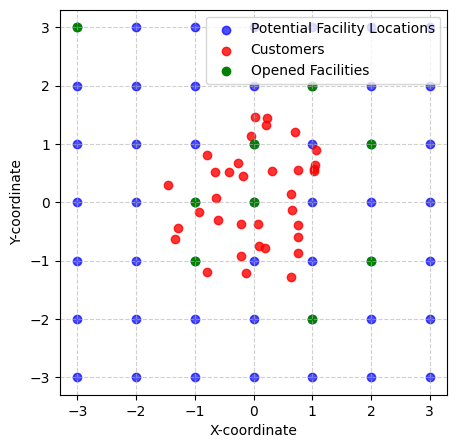

In [20]:
plot_locations(facility_coords[:, y.records["level"] == 1])

Finally, let's compare how much more expansive it would be if we kept the facility selection from our first model.

In [21]:
y.fx[i] = y_beam[i]

cflp_fix_y = gp.Model(
    m,
    name="cflp_fix_y",
    equations=[demand_fulfillment, capacity_constraints, logical_linking],
    problem="MIP",
    sense=gp.Sense.MIN,
    objective=obj,
)

cflp_fix_y.solve(
    solver="CPLEX",
)

print(f"Optimal solution: {cflp_fix_y.objective_value}")
print(f"Number of facilities open: {y.records['level'].sum()}")

Optimal solution: 36033.48997448485
Number of facilities open: 9.0
